In [1]:
# Importing libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Plotting the head of the dataset
dataset = pd.read_csv('../input/an2dl-homework-2/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


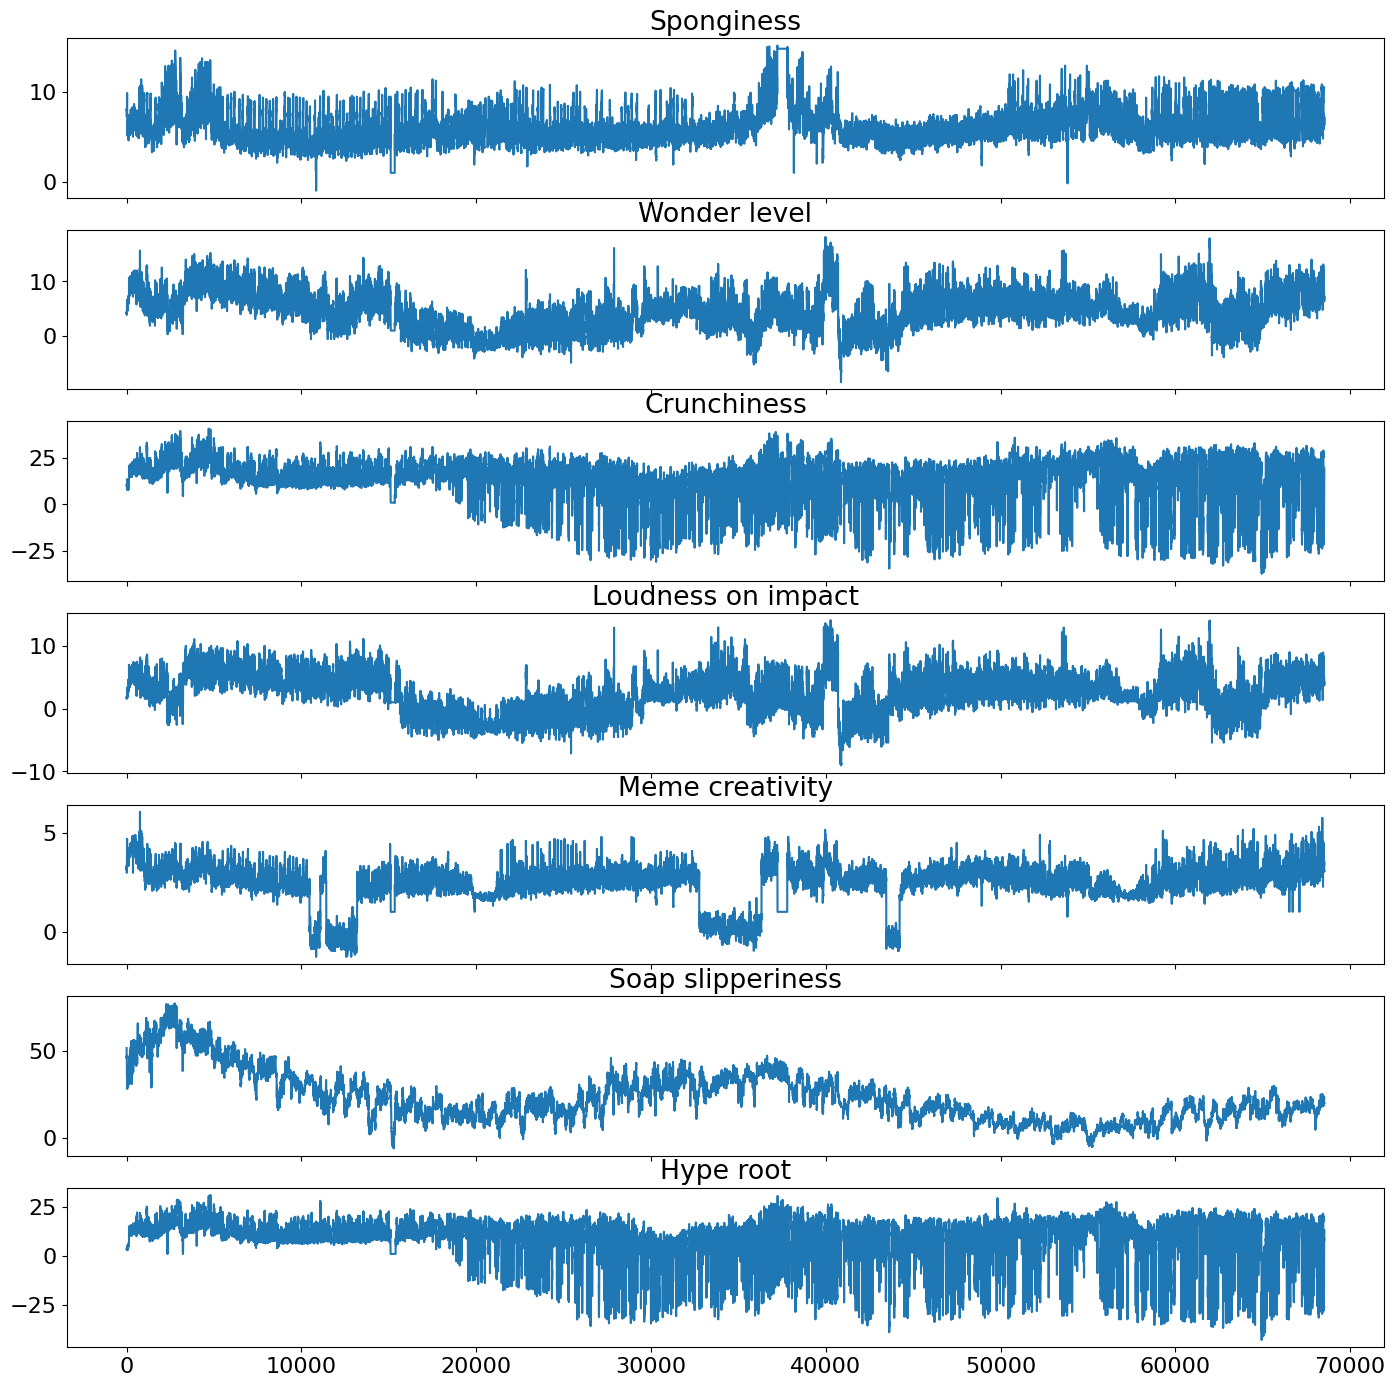

In [3]:
# Function to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

# Plotting time series
inspect_dataframe(dataset, dataset.columns)

In [4]:
# Setting window, stride, validation size, test size and telescope
window = 300
stride = 10
validation_size = 13700
local_test_size = 13700
target_labels = dataset.columns
telescope = 864

In [5]:
# training, validation and test set definitions
X_train_raw = dataset.iloc[:-validation_size-local_test_size]
X_validation_raw = dataset.iloc[-validation_size-local_test_size:-local_test_size]
X_test_raw = dataset.iloc[-validation_size:]

In [6]:
# Computing means on the training set (baseline)
train_means = X_train_raw.mean()

In [7]:
# Function to plot train, validation and test set
def printplots():
    for i in range(X_train_raw.shape[1]):
        plt.figure(figsize=(17,5))
        plt.plot(X_train_raw[(target_labels[i])], label='Train')
        plt.plot(X_validation_raw[(target_labels[i])], label='Validation')
        plt.plot(X_test_raw[(target_labels[i])], label='Test')
        plt.title((target_labels[i]))
        plt.legend()
        plt.show()

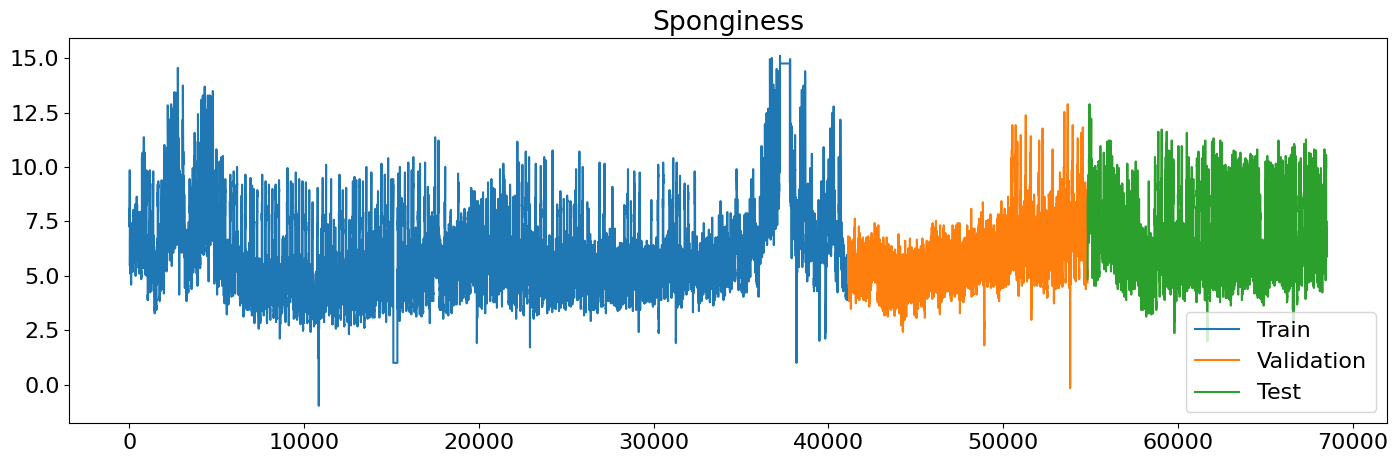

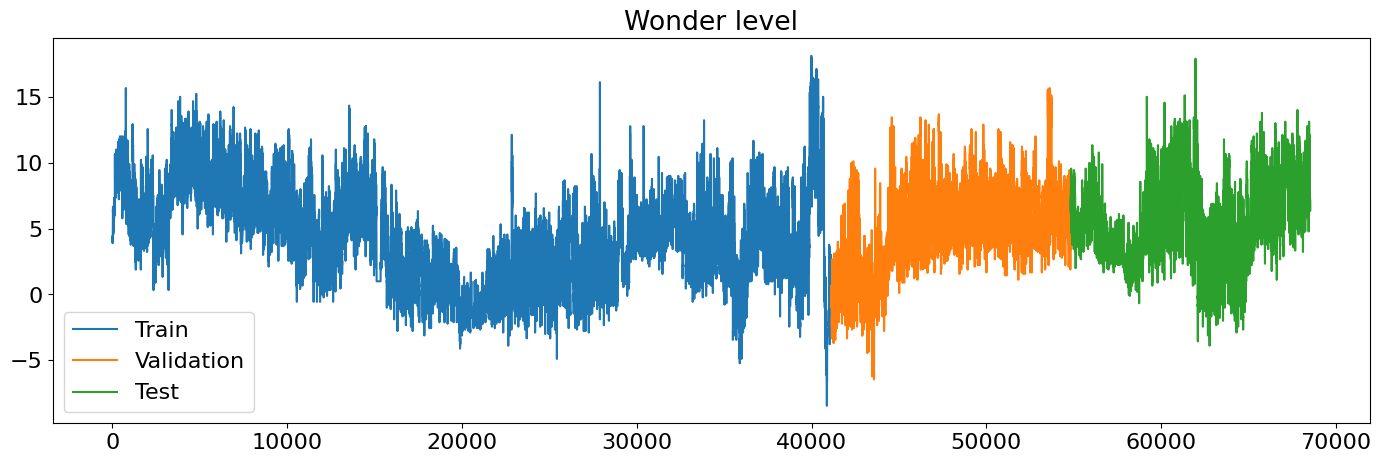

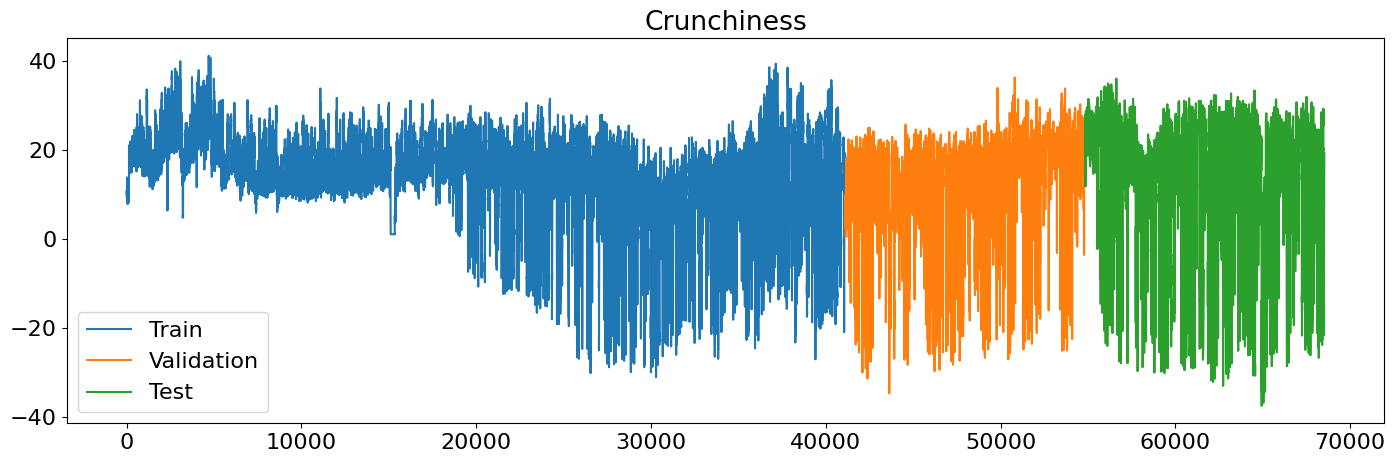

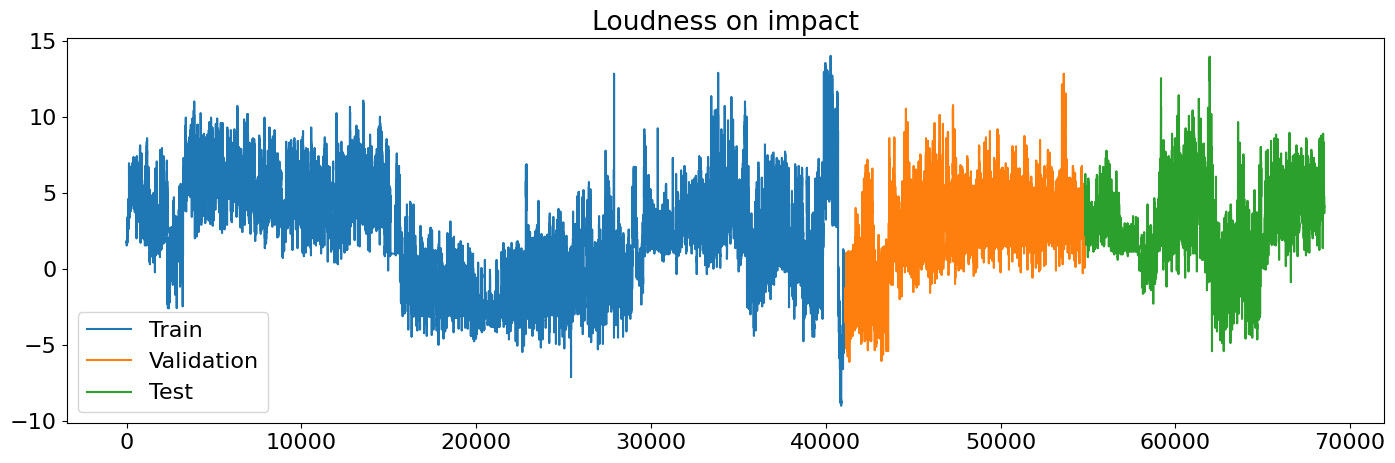

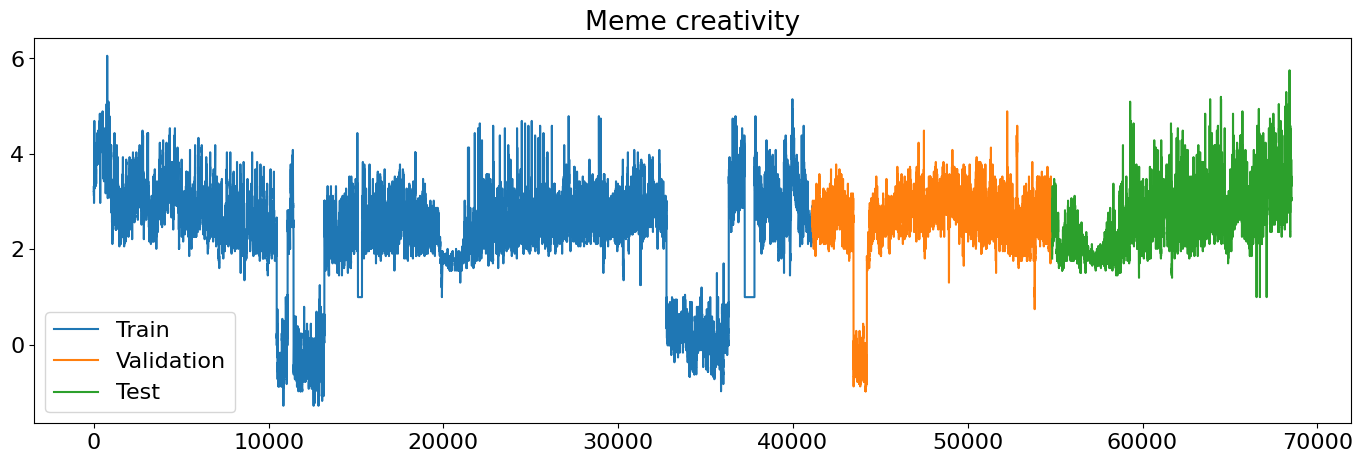

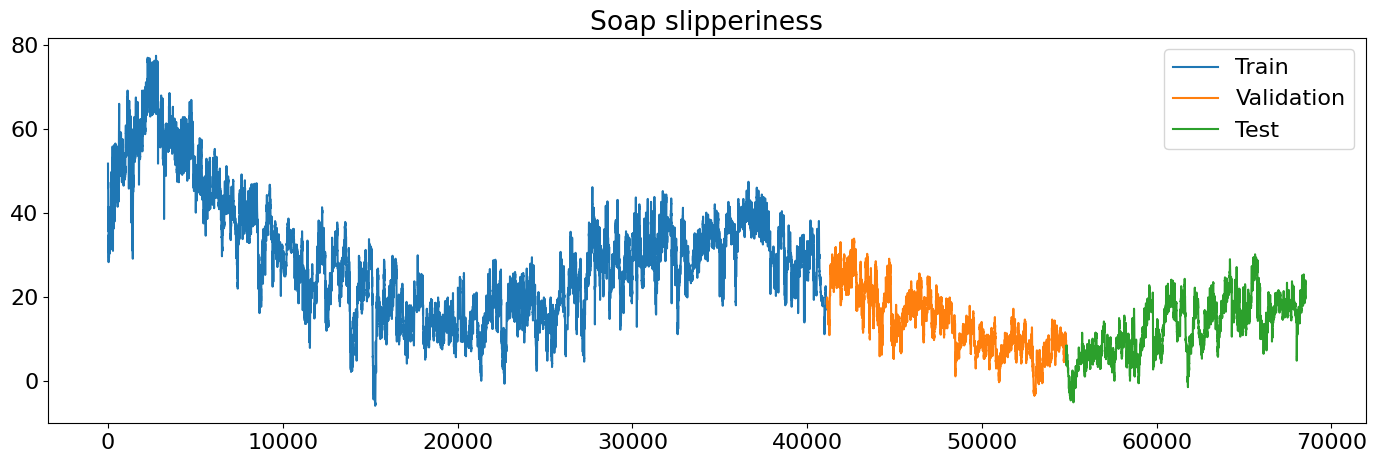

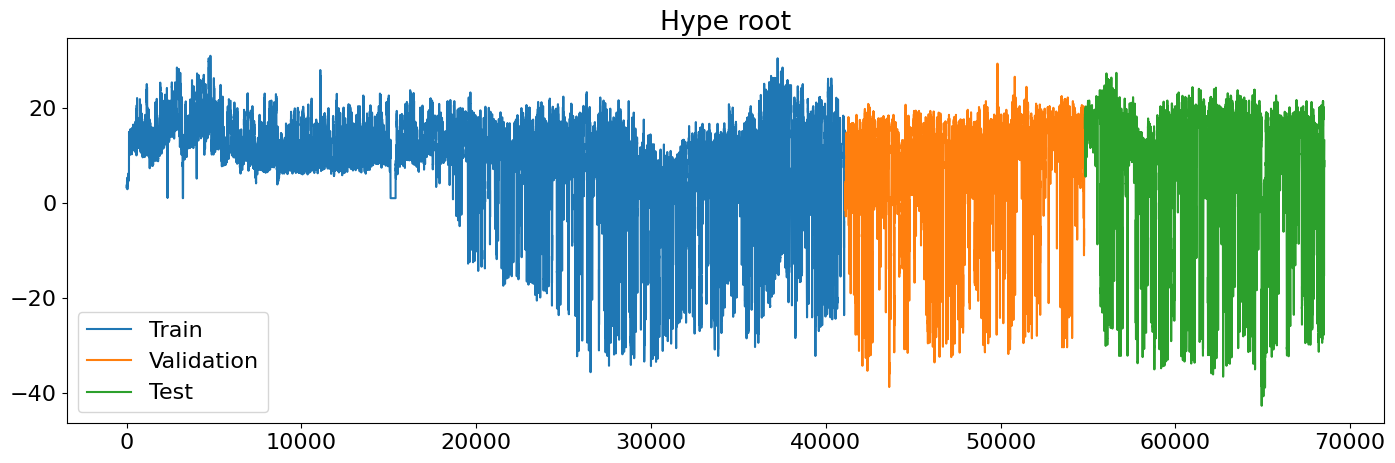

In [8]:
# Plotting train, validation and test set
printplots()

In [9]:
# Function to build windows
def build_sequences(df, target_labels=target_labels, window=window, stride=20, telescope=100):
    
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_val, y_val = build_sequences(X_validation_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4024, 300, 7),
 (4024, 864, 7),
 (1264, 300, 7),
 (1264, 864, 7),
 (1264, 300, 7),
 (1264, 864, 7))

In [11]:
# Predict the test set 
predictions = np.empty((1264, 864, 7))

# Predicting means
for i in range(7):
    predictions[:, :, i] = train_means[i]

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
root_mean_squared_error = mean_squared_error**(1/2)
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, root_mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=109.95842289102667>,
 <tf.Tensor: shape=(), dtype=float64, numpy=10.486106183470902>,
 <tf.Tensor: shape=(), dtype=float64, numpy=6.337465522353231>)

In [12]:
# Function to plot predictions
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(-50,50)
    plt.show()

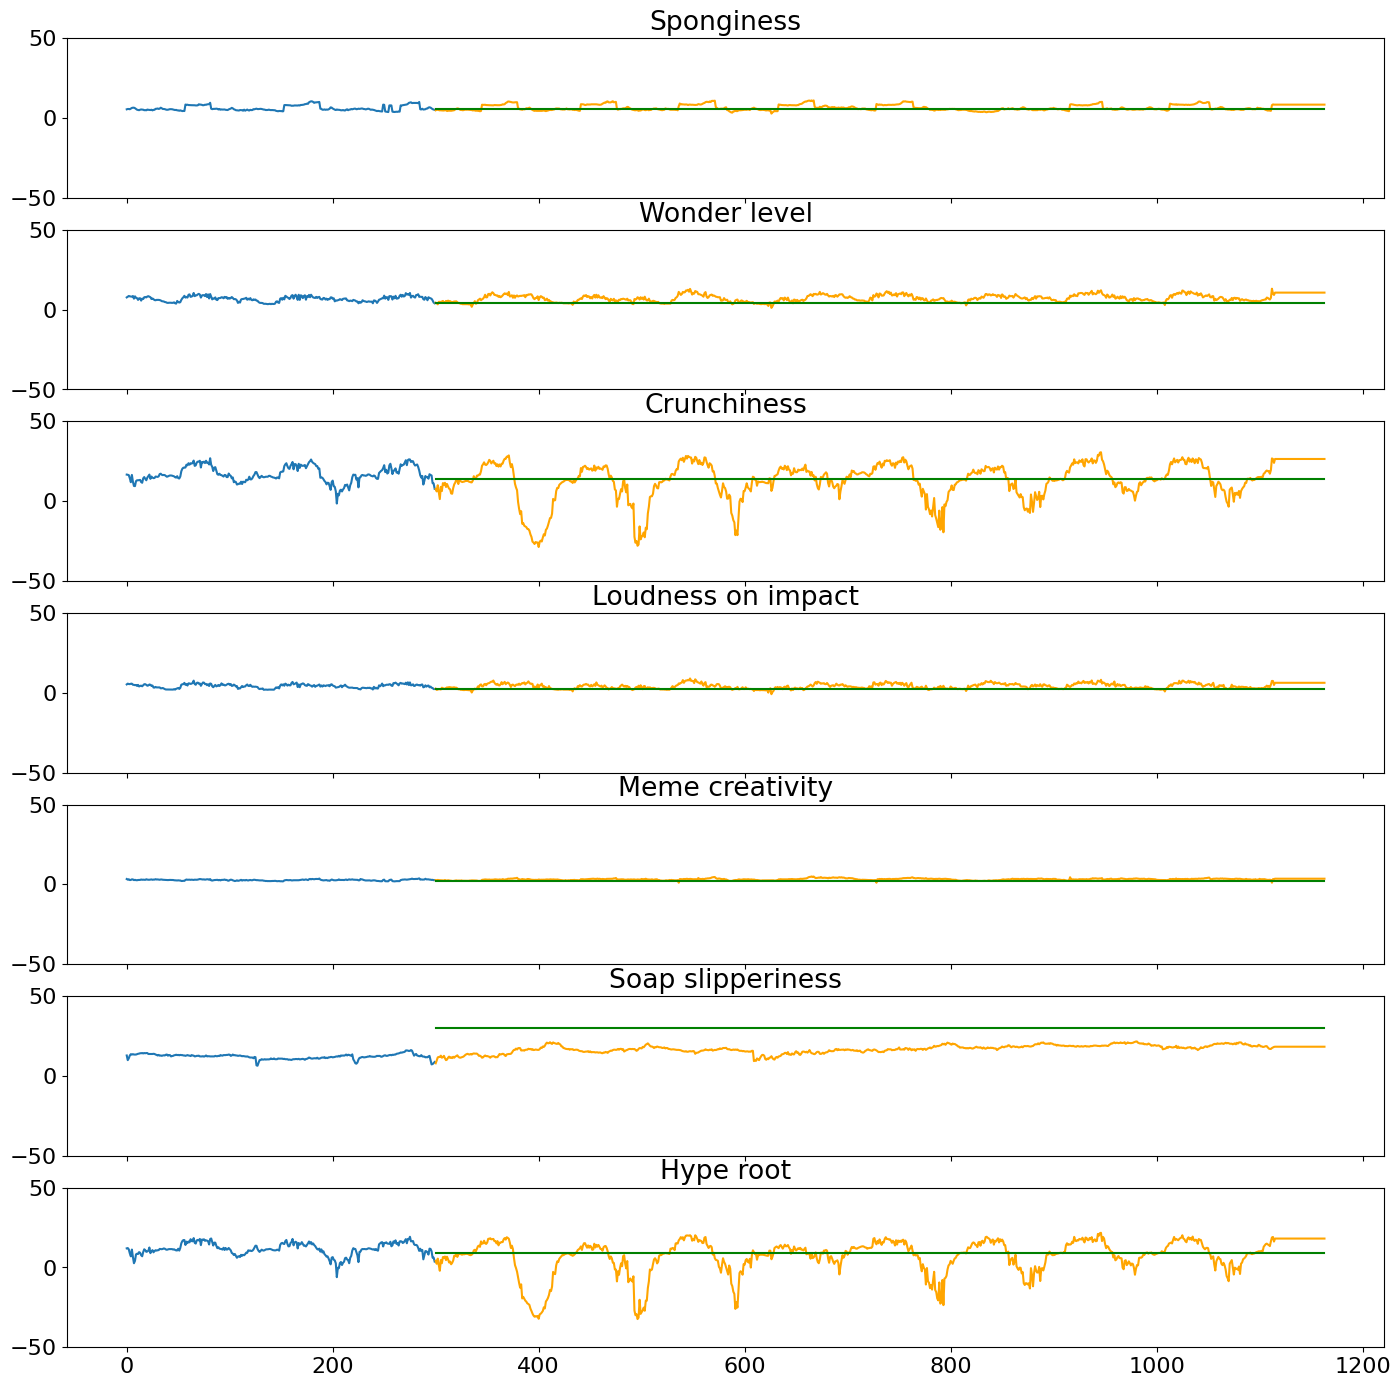

In [13]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)